This notebook does calculation and plotting to test whether the GrainFacetModel, in its "dissolution" configuration---that is, transport-limited with no production of sediment---obeys the formulation in Tucker et al. (2011), which says that the difference in angle between the fault plane ($\alpha_r$) and the facet ($\gamma_r$) equals the ratio of weathering rate, $W$, to slip rate, $V$:

$\alpha_r - \gamma_r = W / V$

Here the $r$ subscript reminds us that the angle measurements are in radians.

One problem, however, is that we do not know the weathering rate *a priori*. Instead, we set the dissolution transition probability, $s$ (dimensions of 1/time). One might expect the resultant weathering rate to simply be cell size times transition rate, $\delta s$. This doesn't quite work, for two reasons. First, there is a geometric correction related to the hex lattice geometry (a "cut" through the lattice would tend to produce 2 faces per cell, and cells have the cross-sectional area of a hexagon). Second, and likely more important, the surface roughens as a result of weathering, which tends to increase the actual rate of weathering. Therefore, we expect the actual weathering rate to be higher than $\delta s$. If we represent this effect with a coefficient, $a>1$, then the above becomes:

$\alpha_r - \gamma_r = a\delta s / V$.

We know $\delta$ and $V$ (which are constants in the model experiments), and $s$ (which is the independent variable), so the hypothesis to test is that there is indeed some $a>1$ that explains the outcome of the model. So the exercise is to do a least-squares linear regression on the above (with a zero intercept) and see whether indeed there is a reasonable fit.


In [9]:
import csv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
filename = 'dissolution_only_results20180717.csv'

In [11]:
# Count number of lines in file
num_lines = len(open(filename).readlines(  ))

# Create data arrays
diss_param = np.zeros(num_lines - 2)  # skip 2 header lines
facet_angle = np.zeros(num_lines - 2)

# Read data
with open(filename, 'r') as csvfile:
    myreader = csv.reader(csvfile)
    i = 0
    for row in myreader:
        print(' '.join(row))
        if i >= 2:
            diss_param[i-2] = row[0]
            facet_angle[i-2] = row[2]
        i += 1

Landlab version 1.4.0+213.gc1191879 
Dissolution rate parameter (1/yr) Gradient (m/m) Slope angle (deg)
4e-05 1.4848188132399602 56.040409696498955
8e-05 1.248837768101174 51.31419028143727
0.00012000000000000002 1.0629500634664806 46.74781453781527
0.00016 0.9375061778667241 43.152578122648315
0.0002 0.8071207219017609 38.90771833154152
0.00024 0.7020705392069188 35.071562342900265
0.00028000000000000003 0.5629313484897664 29.376524262447827
0.00032 0.42841575538113974 23.191054719586457
0.00036 0.2565958550711758 14.391372149373215
0.0004 0.20656848025185617 11.671342495104037
0.00044 0.10706918513524637 6.11133034512308
0.00048 0.09597515674461617 5.482180025836164


In [12]:
filename = 'dissolution_long_domain20190311.csv'

In [13]:
# Count number of lines in file
num_lines = len(open(filename).readlines(  ))

# Create data arrays
diss_param_long = np.zeros(num_lines - 2)  # skip 2 header lines
facet_angle_long = np.zeros(num_lines - 2)

# Read data
with open(filename, 'r') as csvfile:
    myreader = csv.reader(csvfile)
    i = 0
    for row in myreader:
        print(' '.join(row))
        if i >= 2:
            diss_param_long[i-2] = row[0]
            facet_angle_long[i-2] = row[2]
        i += 1

Landlab version 1.7.0+15.g1764eb3f 
Dissolution rate parameter (1/yr) Gradient (m/m) Slope angle (deg)
0.0002 0.82404884912 39.4901895413
0.00024 0.644706866237 32.810153595
0.00028 0.534296429598 28.115431014
0.00032 0.441043524674 23.7995670076
0.00036 0.288452281903 16.0903267272
0.0004 0.201972724765 11.4185726704
0.00044 0.10976357524 6.26391395369
0.00048 0.0224836295957 1.28800007937


(0, 60)

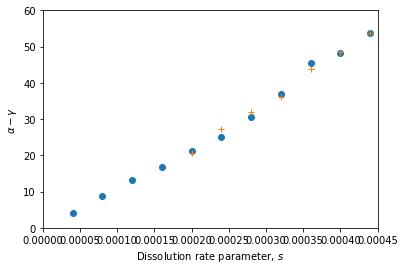

In [14]:
plt.plot(diss_param, 60.0 - facet_angle, 'o')
plt.plot(diss_param_long, 60.0 - facet_angle_long, '+')
plt.xlabel(r'Dissolution rate parameter, $s$')
plt.ylabel(r'$\alpha - \gamma$')
plt.xlim([0, 0.00045])
plt.ylim([0, 60])

There's one other adjustment to note: here, we're working in degrees. Noting that $\alpha = (180/\pi) \alpha_r$ and similarly for $\gamma$, our formula for the angle difference is:

$\alpha - \gamma = \frac{180}{\pi}\frac{a\delta}{V}s = bs$

So if we can fit $b$, we can back out $a$.

In [15]:
# To use linalg.lstsq, we need to transpose $w$
x = diss_param[:,np.newaxis]
y = 60.0 - facet_angle  # angle difference

# Fit with zero intercept (the "rcond" parameter supresses a
# warning)
b, _, _, _ = np.linalg.lstsq(x, y, rcond=None)
print(b)

[116657.64661253]


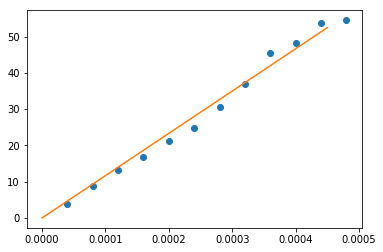

In [16]:
plt.plot(x, y, 'o')
plt.plot([0, 0.00045], [0, b * 0.00045])

Now, to back out $a$, we use:

$a = \frac{\pi V}{180\delta}b$

In these particular model runs, $V=0.001$ m/yr and $\delta=1$ m.

In [17]:
V = 0.001
delta = 1.0
a = b * np.pi * V / (180.0 * delta)
print(a)

[2.03606003]


Wow, this is actually an encouraging result. Our naive expectation is that the effective lowering rate would be $2\delta s$. The factor of 2 comes from the fact that two faces are exposed per hex cell.

The simple expectation is:

$\alpha - \gamma = \frac{360 \delta}{\pi V} s$.

This means that the expected value of $b$ is

$b' = \frac{360 \delta}{\pi V}$.

Is this anywhere near our best fit?

In [18]:
b_exp = 360.0 * delta / (np.pi * V)
print(b_exp)

114591.55902616464


Gorgeous! So now let's simply re-do the plot, but this time with the expected fit:

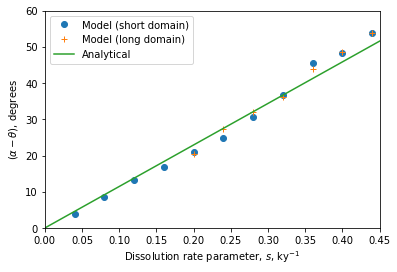

In [19]:
plt.plot(1000.0 * diss_param, y, 'o')
plt.plot(1000.0 * diss_param_long, 60.0 - facet_angle_long, '+')
plt.plot([0.0, 0.45], [0.0, b_exp * 0.00045])
plt.xlabel(r'Dissolution rate parameter, $s$, ky$^{-1}$')
plt.ylabel(r'($\alpha - \theta$), degrees')
plt.xlim([0, 0.45])
plt.ylim([0, 60])
plt.legend(['Model (short domain)', 'Model (long domain)', 'Analytical'])

Here's a slightly different version:

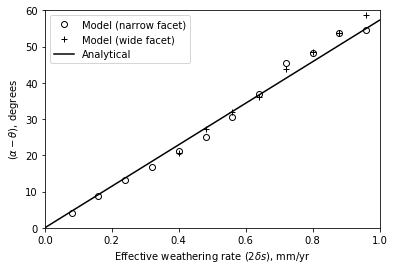

In [22]:
# expected weathering rate, mm/yr
wx_exp = 2.0 * 1000.0 * delta * diss_param
wx_exp_long = 2.0 * 1000.0 * delta * diss_param_long

# 180 / (pi V): the coefficient for 2 delta s (instead of just s)
# The factor of 1000.0 converts V to mm/yr (or m/ky)
c = 180.0 / (np.pi * 1000.0 * V)

plt.plot(wx_exp, y, 'ko', fillstyle='none')
plt.plot(wx_exp_long, 60.0 - facet_angle_long, 'k+')
plt.plot([0.0, 1.0], [0.0, c], 'k')
plt.xlabel(r'Effective weathering rate ($2 \delta s$), mm/yr')
plt.ylabel(r'($\alpha - \theta$), degrees')
plt.xlim([0, 1.0])
plt.ylim([0, 60])
plt.legend(['Model (narrow facet)', 'Model (wide facet)', 'Analytical'])
plt.savefig('../modeling-shape-evolution/Figures/angle_vs_dissolution.pdf')

Here we'll print the corresponding values of $S' = 2 \delta s / V$:

In [16]:
s = 2.0 * delta * diss_param / V
s

array([0.08, 0.16, 0.24, 0.32, 0.4 , 0.48, 0.56, 0.64, 0.72, 0.8 , 0.88,
       0.96])

and corresponding facet angles:

In [17]:
facet_angle

array([56.0404097 , 51.31419028, 46.74781454, 43.15257812, 38.90771833,
       35.07156234, 29.37652426, 23.19105472, 14.39137215, 11.6713425 ,
        6.11133035,  5.48218003])

Predicted facet angle:

In [18]:
theta_pred = np.degrees(np.radians(60.0) - s)
theta_pred

array([55.41633764, 50.83267528, 46.24901292, 41.66535056, 37.08168819,
       32.49802583, 27.91436347, 23.33070111, 18.74703875, 14.16337639,
        9.57971403,  4.99605167])

Side-by-side list

In [19]:
for i in range(len(s)):
    print((s[i], theta_pred[i], facet_angle[i]))

(0.08, 55.416337638953415, 56.040409696498955)
(0.16, 50.83267527790682, 51.31419028143727)
(0.24000000000000002, 46.24901291686024, 46.74781453781527)
(0.32, 41.665350555813646, 43.152578122648315)
(0.4, 37.08168819476707, 38.90771833154152)
(0.48, 32.49802583372048, 35.071562342900265)
(0.56, 27.91436347267389, 29.376524262447827)
(0.64, 23.33070111162731, 23.191054719586457)
(0.7200000000000001, 18.747038750580717, 14.391372149373215)
(0.8, 14.163376389534134, 11.671342495104037)
(0.88, 9.579714028487551, 6.11133034512308)
(0.96, 4.996051667440968, 5.482180025836164)


## Adding predicted dip angle to model images

The following block of code produces plots of the predicted facet angle, to overlay on top of model images.

(50.83267527790682, array([ 0.        , 85.92848531]))
(37.08168819476707, array([ 0.       , 52.9054242]))
(23.33070111162731, array([ 0.        , 30.19123841]))
(9.579714028487551, array([ 0.        , 11.81412231]))


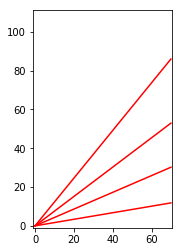

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

s = np.array([0.16, .4, 0.64, .88])
tpred = np.radians(60) - s
for t in tpred:
    x = np.array([0., 70.])
    y = x * np.tan(t)
    print((np.degrees(t), y))
    plt.plot(x, y, 'r')
    plt.axis([-1.0, 70.5, -1.0, 111.0])
    plt.gca().set_aspect('equal')
plt.savefig('predicted_angles.pdf')

Make a plot with the domain twice as long, with $S' = 0.48$:

(37.08168819476707, array([  0.        , 105.81084841]))
(23.33070111162731, array([ 0.        , 60.38247682]))


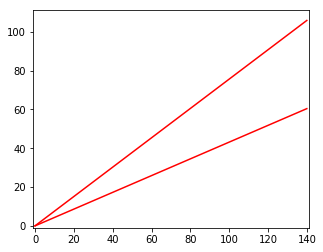

In [4]:
s = np.array([.4, .64])
tpred = np.radians(60) - s
for t in tpred:
    x = np.array([0., 140.])
    y = x * np.tan(t)
    print((np.degrees(t), y))
    plt.plot(x, y, 'r')
    plt.axis([-1.0, 141., -1.0, 111.0])
    plt.gca().set_aspect('equal')
    plt.savefig('predicted_angle_long.pdf')